In [60]:
import itertools
import japanize_matplotlib
import json
import pickle
import random
import statistics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from sklearn.metrics import mean_absolute_error
from tqdm.auto import tqdm

In [7]:
plt.rcParams["font.family"] = "IPAexGothic"

pd.options.display.max_columns = 200
pd.options.display.max_rows = 100

# 重みの読み込み
matrix_dict = {}
for dim in tqdm(range(5, 30)):
    matrix_dict[dim] = [
        np.load(f"nmf_w/train/nmf_w_r{i}/nmf_50000_w_{dim}_r{i}.npy") for i in range(1000)
    ]


# データセットの読み込み
df_result = pd.read_csv("human0821.csv")
df_gt = pd.read_csv("all_data.csv", index_col=0)
df_t = df_gt.T
selected_ids = list(set(df_result["target_ID"]))
df_drop = df_gt.drop(selected_ids, axis=0)
df_train = pd.read_csv("train.csv", index_col=0).T
df_test = pd.read_csv("test.csv", index_col=0)

# NMFの次元数
dims = (5, 10, 15)

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# 推論
def calculate_score(target_id: int, selected_images: list, dims: tuple):
    result = {}
    q_gt = df_gt.iloc[target_id].to_numpy()
    x = df_gt.iloc[target_id, selected_images].to_numpy()

    for dim in dims:
        h_array = []
        result[dim] = {}
        for random_state in range(1000):
            W = matrix_dict[dim][random_state]
            W1 = W[selected_images]
            W1_inv = np.linalg.pinv(W1)
            h_est = np.dot(W1_inv, x)
            h_array.append(h_est)
        h_est_mean = sum(h_array) / len(h_array)
        q = np.dot(W, h_est_mean)
        q[q<0] = 0
        q[q>10] = 10
        result[dim]["q"] = q
        result[dim]["MAE"] = mean_absolute_error(q, q_gt)
    return result

In [ ]:
# 6個のサンプルをランダムに100個生成
random_samples = [sorted(random.sample(range(100), 6)) for _ in range(100)]

with open(f"random_samples_6_100.pkl", "wb") as file:
    pickle.dump(random_samples, file)

In [17]:

# targetを予測
random_state_results = []

for index, row in tqdm(df_result.iterrows()):
    data = {}
    target_ID = row["target_ID"]
    clicked_count = row["clicked_count"]
    clicked_images = sorted([int(x) for x in row["clicked_images"].split(",")])
    q_gt = df_gt.iloc[target_ID].to_numpy()
    x = df_gt.iloc[target_ID, clicked_images].to_numpy()

    target_row = df_gt[df_gt.index==target_ID]
    correct_answers = []

    results = {"q": {}, "MAE": {}}
    for dim in dims:
        q_dict = {}
        MAE_dict = {}
        # random_stateで比較
        for random_state in range(1000):
            W = matrix_dict[dim][random_state]
            W1 = W[clicked_images]
            W1_inv = np.linalg.pinv(W1)
            h_est = np.dot(W1_inv, x)
            q = np.dot(W, h_est)
            q[q < 0] = 0
            q[q > 10] = 10
            q_dict[random_state] = q
            MAE_dict[random_state] = mean_absolute_error(q_gt, q)
        results["q"][dim] = q_dict
        results["MAE"][dim] = MAE_dict
    random_state_results.append(results)

0it [00:00, ?it/s]

808 2.1320029648161563 408 2.1317475888820834
27 2.611433536744565 363 1.8360453147004683
639 2.6584752527013626 476 1.9306953294058986


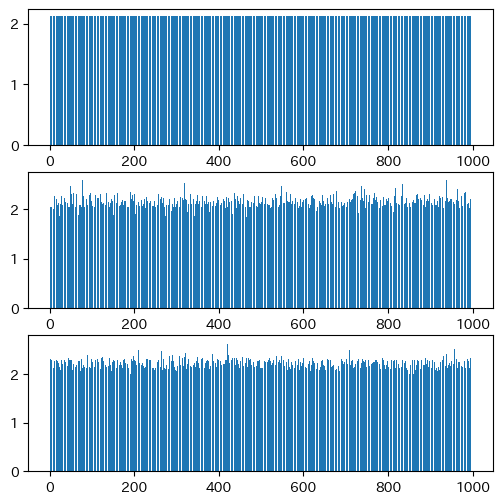

In [39]:
plt.rcParams["figure.figsize"] = (6, 6)
random_state_data = {}
for dim in dims:
    dim_data = {}
    data = np.array([statistics.mean([result["MAE"][dim][random_state] for result in random_state_results]) for random_state in range(1000)])
    dim_data["data"] = data
    dim_data["argmin"] = data.argmin()
    dim_data["min"] = data.min()
    dim_data["argmax"] = data.argmax()
    dim_data["max"] = data.max()
    random_state_data[dim] = dim_data

for index, dim in enumerate(dims):
    plt.subplot(3, 1, index+1)
    print(random_state_data[dim]["argmax"], random_state_data[dim]["max"], random_state_data[dim]["argmin"], random_state_data[dim]["min"])
    plt.bar(x=range(1000), height=random_state_data[dim]["data"])

In [30]:
random_state_data[15]["data"][random_state_data[10]["argmin"]]

2.2188982650810796

In [43]:
random_state_other_results = []

for index, row in tqdm(df_result.iterrows()):
    data = {}
    target_ID = row["target_ID"]
    clicked_count = row["clicked_count"]
    clicked_images = sorted([int(x) for x in row["clicked_images"].split(",")])
    Q_gt = df_test.to_numpy().T
    X = df_test.iloc[:, clicked_images].to_numpy().T

    results = {"Q": {}, "MAE": {}}
    for dim in dims:
        Q_dict = {}
        MAE_dict = {}
        for random_state in range(1000):
            W = matrix_dict[dim][random_state]
            W1 = W[clicked_images]
            W1_inv = np.linalg.pinv(W1)
            H_est = np.dot(W1_inv, X)
            Q = np.dot(W, H_est)
            Q[Q < 0] = 0
            Q[Q > 10] = 10
            Q_dict[random_state] = Q
            MAE_dict[random_state] = mean_absolute_error(Q_gt, Q)
        results["Q"][dim] = Q_dict
        results["MAE"][dim] = MAE_dict
    random_state_other_results.append(results)


0it [00:00, ?it/s]

808 1.959544096766038 408 1.9593857805635944
191 2.4071431387746736 244 2.081527150559991
785 2.544614974027365 86 2.059377613122005


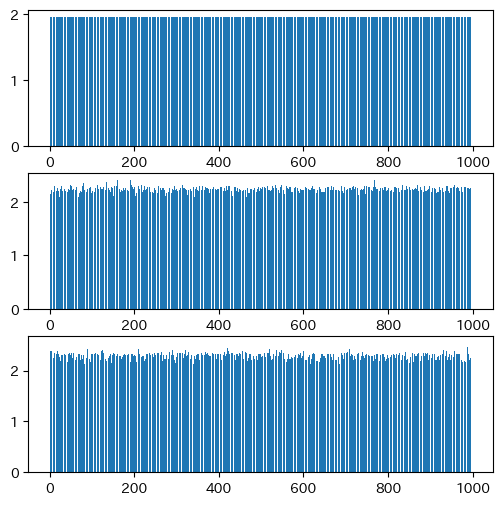

In [41]:
plt.rcParams["figure.figsize"] = (6, 6)
random_state_other_data = {}
for dim in dims:
    dim_data = {}
    data = np.array([statistics.mean([result["MAE"][dim][random_state] for result in random_state_other_results]) for random_state in range(1000)])
    dim_data["data"] = data
    dim_data["argmin"] = data.argmin()
    dim_data["min"] = data.min()
    dim_data["argmax"] = data.argmax()
    dim_data["max"] = data.max()
    random_state_other_data[dim] = dim_data

for index, dim in enumerate(dims):
    plt.subplot(3, 1, index+1)
    print(random_state_other_data[dim]["argmax"], random_state_other_data[dim]["max"], random_state_other_data[dim]["argmin"], random_state_other_data[dim]["min"])
    plt.bar(x=range(1000), height=random_state_other_data[dim]["data"])

In [49]:
matrix_dict[5][0].shape

(100, 5)

In [76]:
W_effect_data = {}
W_effect_elm = {}

for dim in dims:
    dim_data = {}
    print(f"{dim} dimensions")
    W_mean_t = (sum(matrix_dict[dim]).T)/1000
    W_effect_elm[dim] = W_mean_t.T
    for index, elm in enumerate(W_mean_t):
        elm_data = {}
        elm_data["max"] = {
            "arg": int(elm.argmax()),
            "value": elm.max()
        }
        elm_data["min"] = {
            "arg": int(elm.argmin()),
            "value": elm.min()
        }
        elm_data["mean"] = elm.mean()
        elm_data["median"] = np.median(elm)
        dim_data[index] = elm_data
    W_effect_data[dim] = dim_data

with open("W_effect_data.json", "w") as f:
    json.dump(W_effect_data, f, indent=2)

5 dimensions
10 dimensions
15 dimensions


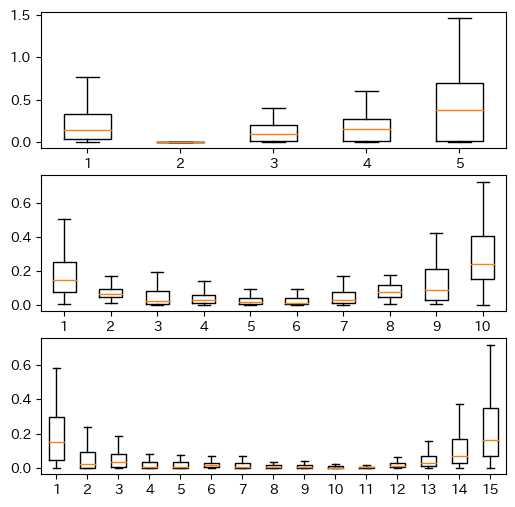

In [77]:
for index, dim in enumerate(dims):
    plt.subplot(3, 1, index+1)
    plt.boxplot(W_effect_elm[dim], sym="", vert=True)

In [99]:
argmax_edge = set()

for dim in dims:
    argmax_edge.add(W_effect_data[dim][0]["max"]["arg"])
    argmax_edge.add(W_effect_data[dim][dim-1]["max"]["arg"])

print(sorted(argmax_edge))

argmax_edge_results = []
for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, sorted(argmax_edge), dims)
    argmax_edge_results.append(result)

MAE_argmax_edge = {5: [], 10: [], 15: []}
for result in argmax_edge_results:
    for dim in dims:
        MAE_argmax_edge[dim].append(result[dim]["MAE"])

[3, 8, 12, 40, 69, 74]


0it [00:00, ?it/s]

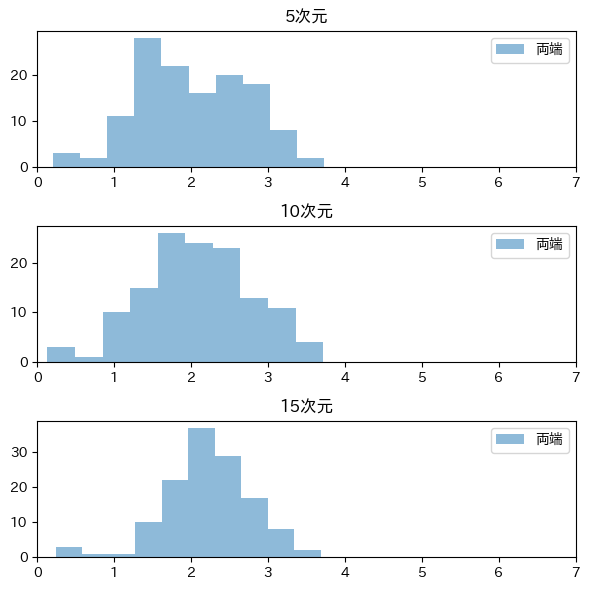

In [101]:
plt.rcParams["figure.figsize"] = (6, 6)
for index, dim in enumerate(dims):
    plt.subplot(3, 1, index+1)
    plt.hist(MAE_argmax_edge[dim], label="両端", alpha=0.5)
    plt.title(f"{dim}次元")
    plt.xlim(0, 7)
    plt.legend()

plt.tight_layout()

In [102]:
df_MAE_argmax_edge = pd.DataFrame({'5次元':MAE_argmax_edge[5],'10次元':MAE_argmax_edge[10],'15次元':MAE_argmax_edge[15]})
df_MAE_argmax_edge.describe()

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,2.014183,2.083080,2.201276
std,0.702395,0.703187,0.567338
min,0.203369,0.132840,0.238934
25%,1.496154,1.609774,1.892345
50%,1.915759,2.078687,2.179970
75%,2.602286,2.596711,2.568426
max,3.732499,3.716928,3.683191


In [112]:
elm_argmax_5 = set()
elm_argmax_5.add(W_effect_data[5][0]["max"]["arg"])
elm_argmax_5.add(W_effect_data[5][2]["max"]["arg"])
elm_argmax_5.add(W_effect_data[5][3]["max"]["arg"])
elm_argmax_5.add(W_effect_data[5][4]["max"]["arg"])
elm_argmax_5.add(np.argsort(W_effect_elm[5].T[0])[-2])
elm_argmax_5.add(np.argsort(W_effect_elm[5].T[4])[-2])

print(elm_argmax_5)

elm_argmax_5_results = []
for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, sorted(elm_argmax_5), dims)
    elm_argmax_5_results.append(result)

MAE_elm_argmax_5 = {5: [], 10: [], 15: []}
for result in elm_argmax_5_results:
    for dim in dims:
        MAE_elm_argmax_5[dim].append(result[dim]["MAE"])

df_MAE_elm_argmax_5 = pd.DataFrame({'5次元':MAE_elm_argmax_5[5],'10次元':MAE_elm_argmax_5[10],'15次元':MAE_elm_argmax_5[15]})
df_MAE_elm_argmax_5.describe()

{3, 69, 70, 8, 86, 22}


0it [00:00, ?it/s]

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,3.256253,1.770708,2.318010
std,1.500814,0.530503,0.760271
min,0.117414,0.270327,0.250345
25%,2.160439,1.415444,1.841866
50%,3.067879,1.763628,2.291728
75%,4.253250,2.113255,2.646197
max,7.639032,3.023144,5.143271


In [114]:
elm_argmax_10 = set()
elm_argmax_10.add(W_effect_data[10][0]["max"]["arg"])
elm_argmax_10.add(W_effect_data[10][2]["max"]["arg"])
elm_argmax_10.add(W_effect_data[10][6]["max"]["arg"])
elm_argmax_10.add(W_effect_data[10][7]["max"]["arg"])
elm_argmax_10.add(W_effect_data[10][8]["max"]["arg"])
elm_argmax_10.add(W_effect_data[10][9]["max"]["arg"])
print(elm_argmax_10)

elm_argmax_10_results = []
for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, sorted(elm_argmax_10), dims)
    elm_argmax_10_results.append(result)

MAE_elm_argmax_10 = {5: [], 10: [], 15: []}
for result in elm_argmax_10_results:
    for dim in dims:
        MAE_elm_argmax_10[dim].append(result[dim]["MAE"])

df_MAE_elm_argmax_10 = pd.DataFrame({'5次元':MAE_elm_argmax_10[5],'10次元':MAE_elm_argmax_10[10],'15次元':MAE_elm_argmax_10[15]})
df_MAE_elm_argmax_10.describe()

{0, 3, 12, 47, 87, 89}


0it [00:00, ?it/s]

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,2.238246,1.789276,2.292296
std,0.792326,0.525887,0.731828
min,0.090000,0.090000,0.090000
25%,1.745007,1.483254,1.897062
50%,2.276807,1.804008,2.259393
75%,2.715937,2.094537,2.600935
max,5.426617,3.127342,5.399662


In [115]:
elm_argmax_15 = set()
elm_argmax_15.add(W_effect_data[15][0]["max"]["arg"])
elm_argmax_15.add(W_effect_data[15][1]["max"]["arg"])
elm_argmax_15.add(W_effect_data[15][2]["max"]["arg"])
elm_argmax_15.add(W_effect_data[15][12]["max"]["arg"])
elm_argmax_15.add(W_effect_data[15][13]["max"]["arg"])
elm_argmax_15.add(W_effect_data[15][14]["max"]["arg"])
print(elm_argmax_15)

elm_argmax_15_results = []
for index, row in tqdm(df_test.iterrows()):
    result = calculate_score(row.name, sorted(elm_argmax_15), dims)
    elm_argmax_15_results.append(result)

MAE_elm_argmax_15 = {5: [], 10: [], 15: []}
for result in elm_argmax_15_results:
    for dim in dims:
        MAE_elm_argmax_15[dim].append(result[dim]["MAE"])

df_MAE_elm_argmax_15 = pd.DataFrame({'5次元':MAE_elm_argmax_15[5],'10次元':MAE_elm_argmax_15[10],'15次元':MAE_elm_argmax_15[15]})
df_MAE_elm_argmax_15.describe()

{64, 2, 3, 37, 40, 74}


0it [00:00, ?it/s]

,5次元,10次元,15次元
count,130.000000,130.000000,130.000000
mean,1.758497,1.706141,2.204813
std,0.640954,0.515121,0.641881
min,0.090000,0.090000,0.090000
25%,1.365274,1.372573,1.855866
50%,1.697582,1.640875,2.206865
75%,2.210470,2.045389,2.591355
max,3.698794,3.029448,3.634630


In [117]:
for value in W_effect_data[10].values():
    print(value)

{'max': {'arg': 3, 'value': 0.7860346620898562}, 'min': {'arg': 36, 'value': 0.0033826899959474087}, 'mean': 0.18220490046445914, 'median': 0.14775883342862195}
{'max': {'arg': 8, 'value': 0.20927346392422336}, 'min': {'arg': 69, 'value': 0.010042412990883837}, 'mean': 0.07814091538427026, 'median': 0.06752253529042218}
{'max': {'arg': 0, 'value': 0.27301604678600494}, 'min': {'arg': 73, 'value': 0.0}, 'mean': 0.054085444357812346, 'median': 0.024322650649225605}
{'max': {'arg': 32, 'value': 0.2923791560324325}, 'min': {'arg': 29, 'value': 0.0}, 'mean': 0.04544224315691749, 'median': 0.026647382583102994}
{'max': {'arg': 63, 'value': 0.14200305054628637}, 'min': {'arg': 73, 'value': 0.0}, 'mean': 0.027466594244542262, 'median': 0.017892143468179453}
{'max': {'arg': 58, 'value': 0.13111127083298607}, 'min': {'arg': 73, 'value': 0.0}, 'mean': 0.027120523462192264, 'median': 0.01307280893786663}
{'max': {'arg': 47, 'value': 0.23077024087538212}, 'min': {'arg': 73, 'value': 0.0}, 'mean': 0

In [118]:
for value in W_effect_data[15].values():
    print(value)

{'max': {'arg': 40, 'value': 0.5803511074937848}, 'min': {'arg': 8, 'value': 0.0}, 'mean': 0.18890627110230362, 'median': 0.15422933936509325}
{'max': {'arg': 3, 'value': 0.46997074484116486}, 'min': {'arg': 54, 'value': 0.0}, 'mean': 0.07338759088751111, 'median': 0.026552412221734267}
{'max': {'arg': 2, 'value': 0.2643150514148712}, 'min': {'arg': 73, 'value': 0.0}, 'mean': 0.052071070622855604, 'median': 0.03274402238430786}
{'max': {'arg': 32, 'value': 0.36006900340096987}, 'min': {'arg': 3, 'value': 0.0}, 'mean': 0.031018997800081913, 'median': 0.005181196611220317}
{'max': {'arg': 77, 'value': 0.17942204265136302}, 'min': {'arg': 9, 'value': 0.0}, 'mean': 0.025792537848062475, 'median': 0.008775102082330358}
{'max': {'arg': 90, 'value': 0.09749688972530206}, 'min': {'arg': 6, 'value': 0.0}, 'mean': 0.021131725672476672, 'median': 0.015363493269363216}
{'max': {'arg': 36, 'value': 0.19668894938641807}, 'min': {'arg': 8, 'value': 1.0928972773711126e-05}, 'mean': 0.02597061889755911

In [ ]:
for i in (1, 2, 3, 6):
    